# Unconditioned Symbolic Music Generation using WaveNet

### Import Libraries

In [ ]:
import os
import music21 
import pandas as pd
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm
import shutil
from midi2audio import FluidSynth

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

### <span style="color:red">1. Exploratory analysis, data collection, pre-processing, and discussion -- Context</span>

We used **[MAESTRO](https://magenta.tensorflow.org/datasets/maestro)** (MIDI and Audio Edited for Synchronous TRacks and Organization) and the following is the general information about this dataset

* The dataset comes from the International Piano-e-Competition. During each competition, performances by professional pianists are recorded using Yamaha Disklaviers — concert-quality acoustic grand pianos that include a high-precision MIDI capture and playback system.

* This dataset contains both MIDI and audio data:
    * Audio: High-fidelity stereo recordings at 44.1–48 kHz 16-bit PCM quality.
	* MIDI: High-resolution symbolic data capturing key strike velocities and detailed pedal controls.

* This dataset can be used for MIR, music generation, etc.

* The dataset contains midi files of multiple composers and we mixed them together as our dataset instead of using one single composer. We believe this can create music in diverse styles.

In [2]:
midi_dataroot = "data/maestro-v3.0.0-midi"
np_dataroot = "data/maestro-v3.0.0-numpy"
simplify_composer_name = {
    "Frédéric Chopin": "chopin",
    "Franz Schubert": "schubert",
    "Ludwig van Beethoven": "beethoven",
    "Johann Sebastian Bach": "bach",
    "Franz Liszt": "liszt"}
full_composer_name = {v: k for k, v in simplify_composer_name.items()}

### <span style="color:red">1. Exploratory analysis, data collection, pre-processing, and discussion -- Discussion & Code</span>
I combined these 2 parts together for better demonstration.

##### Step 1: Read midi file and extract notes and chords and then save extracted information as numpy files since extraction takes a long time.

In [ ]:
# This function is borrowed from https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
def read_midi(file):    
    notes=[]
    notes_to_parse = None
    midi = music21.converter.parse(file)
    s2 = music21.instrument.partitionByInstrument(midi)
    for part in s2.parts:
        if 'Piano' in str(part): 
            notes_to_parse = part.recurse() 
            for element in notes_to_parse:
                if isinstance(element, music21.note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, music21.chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
    return np.array(notes)

In [ ]:
# read file names
midi_df = pd.read_csv(os.path.join(midi_dataroot, "maestro-v3.0.0.csv"))
midi_files = midi_df['midi_filename'].tolist()
np_files = [d.replace('.midi', '.npy') for d in midi_files]

# save midi extracted notes to numpy files
for idx, (midi_file, np_file) in enumerate(zip(midi_files, np_files)):
    tik = time.time()
    notes = read_midi(os.path.join(midi_dataroot, midi_file))
    numpy_filename = os.path.join(np_dataroot, np_file)
    np.save(numpy_filename, notes)
    tok = time.time()
    print(f"Processed {idx+1}/{len(midi_files)} -- Time taken: {tok-tik:.2f}s")

##### Step 2: Check out the number of unique notes/chords 

In [45]:
composer_name = 'all' 
midi_df = pd.read_csv(os.path.join(midi_dataroot, "maestro-v3.0.0.csv"))
if composer_name == 'all':
    selected_midi_files = midi_df['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]
else:
    composer_name_ = full_composer_name[composer_name]
    selected_midi_files = midi_df[midi_df['canonical_composer'] == composer_name_]['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]

allpieces = [np.load(os.path.join(np_dataroot, np_file)) for np_file in selected_np_files]
allnotes = np.concatenate(allpieces)
print(f"Total Number of Unique Notes/Chords: {len(set(allnotes))}")

Total Number of Unique Notes/Chords: 3158


##### Step 3: Reduce the Vocab Size

From the above we can see that there are 3158 unique notes/chords in the dataset. This is a very large vocabulary size and we need to reduce it to make the model training feasible. We can do this by selecting the most frequent notes/chords and discarding the rest.

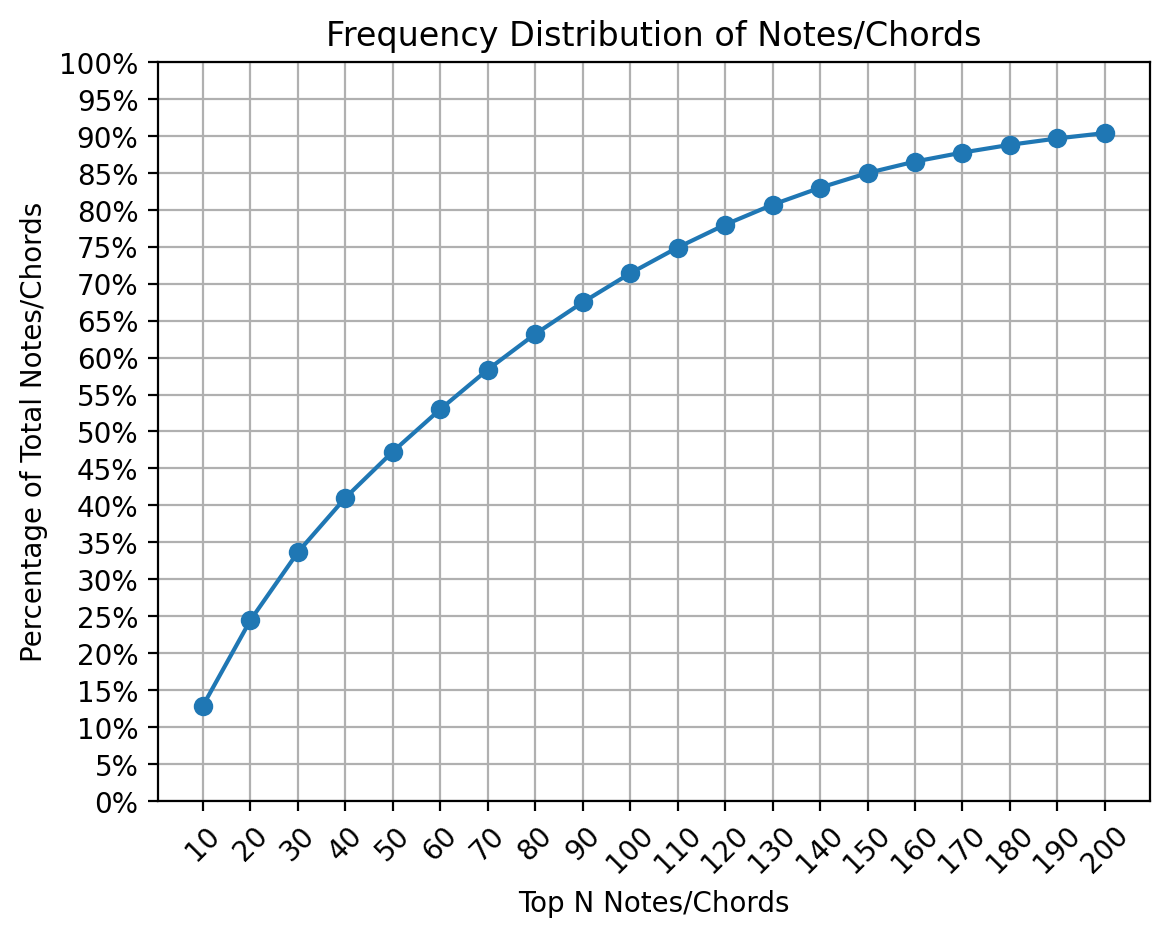

In [56]:
composer_name = 'all' 
midi_df = pd.read_csv(os.path.join(midi_dataroot, "maestro-v3.0.0.csv"))
if composer_name == 'all':
    selected_midi_files = midi_df['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]
else:
    composer_name_ = full_composer_name[composer_name]
    selected_midi_files = midi_df[midi_df['canonical_composer'] == composer_name_]['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]

allpieces = [np.load(os.path.join(np_dataroot, np_file)) for np_file in selected_np_files]


# calculate the frequency of each note/chord
counter = defaultdict(int)
for piece in allpieces:
    for note in piece:
        counter[note] += 1

freq = [(counter[d], d) for d in counter]
freq.sort(reverse=True)
total = sum([f[0] for f in freq])
topNs = [i*10 for i in range(1, 21)]
percentages = [ sum([f[0] for f in freq[:topN]])/total for topN in topNs]

plt.plot(topNs, percentages, marker='o')
plt.xlabel('Top N Notes/Chords')
plt.xticks(topNs, rotation=45) 
plt.yticks(np.arange(0, 1.01, 0.05), [f"{int(i*100)}%" for i in np.arange(0, 1.01, 0.05)])
plt.grid()
plt.ylabel('Percentage of Total Notes/Chords')
plt.title(f"Frequency Distribution of Notes/Chords")
plt.show()

##### Step 4: Save Related Information

We can see that top 160 notes/chords cover 85% of the dataset. So we can reduce the vocabulary size to 160. Now, we save related information about top 160 notes/chords in a dictionary and save it as a json file. This will be used later for decoding the generated music.

In [54]:
topNNotesChord = 160
selectedNotesChord = [f[1] for f in freq[:topNNotesChord]]
composer_name = 'all'

# recalculate the freq and probability of selected notes/chords
selectedFreqProb = {}
total = sum([f[0] for f in freq[:topNNotesChord]])
for idx, f in enumerate( freq[:topNNotesChord] ):
    selectedFreqProb[f[1]] = {'id': idx, 'freq': f[0], 'prob': f[0]/total}

# save the selected notes/chords to a json file
with open(os.path.join(np_dataroot, 'features', composer_name, 'selectedNotesChord.json'), 'w') as f:
    json.dump(selectedFreqProb, f, indent=4)

##### Step 5: Generate trainX and trainY with a sliding window of size 32(context length) to make the model training feasible.

In [ ]:
# read the selected notes/chords from the json file
composer_name = 'all'
with open(os.path.join(np_dataroot, 'features', composer_name, 'selectedNotesChord.json'), 'r') as f:
    selectedNCInfo = json.load(f)
id2note = {}
for note in selectedNCInfo:
    id2note[selectedNCInfo[note]['id']] = note

# get all the file names 
CONTEXTLENGTH = 32
midi_df = pd.read_csv(os.path.join(midi_dataroot, "maestro-v3.0.0.csv"))
if composer_name == 'all':
    selected_midi_files = midi_df['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]
else:
    composer_name_ = full_composer_name[composer_name]
    selected_midi_files = midi_df[midi_df['canonical_composer'] == composer_name_]['midi_filename'].tolist()
    selected_np_files = [d.replace('.midi', '.npy') for d in selected_midi_files]

# collect all pieces
allpieces = [np.load(os.path.join(np_dataroot, np_file)) for np_file in selected_np_files]

# generate features
X = []
y = []
for idx, piece in enumerate(allpieces):
    tik = time.time()
    for i in range(len(piece) - CONTEXTLENGTH - 1):
        clip = piece[i : i + CONTEXTLENGTH + 1]
        # check if all notes/chords in the clip are in the selected notes/chords
        all_in = all([d in selectedNCInfo for d in clip])
        if all_in:
            X.append([selectedNCInfo[d]['id'] for d in clip[:-1]])
            y.append([selectedNCInfo[d]['id'] for d in clip[1:]])
    tok = time.time()
    print(f"Processed {idx+1}/{len(allpieces)} -- Time taken: {tok-tik:.2f}s")

# convert to numpy arrays and then save features   
X = np.array(X)
y = np.array(y)

# save the features
np.save(os.path.join(np_dataroot, 'features', composer_name, f'X{CONTEXTLENGTH}_many_many.npy'), X)
np.save(os.path.join(np_dataroot, 'features', composer_name, f'y{CONTEXTLENGTH}_many_many.npy'), y)
print(f"Finished saving features: X shape {X.shape}, y shape {y.shape}")

### <span style="color:red">2. Modeling -- Context</span>

1. ML Task Formulation: We are going to use a sequence-to-sequence model to generate music. The input will be a sequence of notes/chords and the output will be the next note/chord in the sequence.

2. We experimented 3 different models:
    * **Random (baseline)**: Generate random notes/chords from the vocabulary according to the probability distribution of the training data.
    * **LSTM (baseline)**: Generate next token based on the previous token, hidden state and cell state.
    * **[WaveNet](https://arxiv.org/pdf/1609.03499)**: Generate next token based on the previous tokens(depends on receptive field).

3. For inputs and outputs, it's different for training and inference.
    * Training:
        * Input: A sequence of notes/chords of size 32, $[x_i, x_{i+1} \cdots x_{i+31}]$.
        * Target: The next note/chord at each step, $[x_{i+1}, x_{i+2} \cdots x_{i+32}]$.
        * Output: The model output should in shape of (batch size, seqence length, vocab size), the sequence length is 32 in our case.
        * The above stays the same for both LSTM and WaveNet models.


    * Inference:
        * Input: 
            * For LSTM: The previous note/chord, cell state and hidden state.
            * For WaveNet: A sequence of previous notes/chords of receptive field size.
        
        * Output: The next note/chord in the sequence.

4. Optimiztion: The next note/chord prediction accuracy is used as the optimization metric. So we can use cross entropy loss as the loss function. We can treat the training process as a classification problem because the output is a probability distribution over the vocabulary. Higher accuracy means that the model can better represent the music distribution of the training set.

### <span style="color:red">2. Modeling -- Discussion</span>

Since **Random** Generation does not need any training, we won't discuss it here.

So we compare **LSTM** and **WaveNet** models in the following aspects:

* Implementation Complexity: LSTM is simpler to implement than WaveNet since pytorch has a built-in LSTM module. For WaveNet, we need to implement the dilated convolution and residual connection ourselves.

* Training Time: LSTM is much faster to train than WaveNet since it has fewer parameters and the training process is simpler. WaveNet has a larger receptive field and requires more computation to generate the next note/chord.

* Inference Time: LSTM is also faster for the same reason as above.

* Long-Term Dependencies: WaveNet can capture long-term dependencies better than LSTM since it has a larger receptive field. LSTM may not capture long-term dependencies well since it only uses a cell state to represent the long term memory.

### <span style="color:red">2. Modeling -- Code</span>

##### LSTM

In [57]:
class LSTMSequenceTagger(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        logits = self.fc(output)
        return logits

##### WaveNet

<img src="images/wavenet.png" width="600"/> <img src="images/causalConv.png" width="600"/>

In [58]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        # calculate padding size
        self.pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        # do not use future information, so we need to remove the padding
        x = x[..., :-self.pad] 
        return x


class ResidualLayer(nn.Module):    
    def __init__(self, residual_size, skip_size, dilation):
        super(ResidualLayer, self).__init__()
        self.conv_filter = CausalConv1d(residual_size, residual_size, kernel_size=2, dilation=dilation)
        self.conv_gate   = CausalConv1d(residual_size, residual_size,kernel_size=2, dilation=dilation)        
        self.resconv1_1 = nn.Conv1d(residual_size, residual_size, kernel_size=1)
        self.skipconv1_1 = nn.Conv1d(residual_size, skip_size, kernel_size=1)
        
    def forward(self, x):
        conv_filter = self.conv_filter(x)
        conv_gate = self.conv_gate(x)  
        fx = F.tanh(conv_filter) * F.sigmoid(conv_gate)
        fx = self.resconv1_1(fx) 
        skip = self.skipconv1_1(fx) 
        residual = fx + x
        return skip, residual


class DilatedStack(nn.Module):
    def __init__(self, residual_size, skip_size, dilation_depth):
        super(DilatedStack, self).__init__()
        # 2 ** layer means the dilation size
        residual_stack = [ResidualLayer(residual_size, skip_size, 2**layer) for layer in range(dilation_depth)]
        self.residual_stack = nn.ModuleList(residual_stack)
        
    def forward(self, x):
        skips = []
        for layer in self.residual_stack:
            skip, x = layer(x)
            skips.append(skip.unsqueeze(0))
        return torch.cat(skips, dim=0), x  



class WaveNet(nn.Module):

    def __init__(self, embed_dim, num_class, residual_size, skip_size, end_size, stack_size, dilation_depth):
        # embed_dim: input feature dimension
        # num_class: vocabulary size
        # residual_size: residual size
        # skip_size: skip size
        # end_size: this is the input size of the last 1x1 conv layer
        # stack_size: how many stacks are placed together
        # dilation_depth: how many dialiation layers are in each stack

        self.embed_dim = embed_dim

        super(WaveNet, self).__init__()

        self.embedding = nn.Embedding(num_class, embed_dim)
        self.input_conv = CausalConv1d(embed_dim, residual_size, kernel_size=2)        
        self.dilated_stacks = nn.ModuleList( [DilatedStack(residual_size, skip_size, dilation_depth) for _ in range(stack_size)])
        self.convout_1 = nn.Conv1d(skip_size, end_size, kernel_size=1)
        self.convout_2 = nn.Conv1d(end_size, num_class, kernel_size=1)
        self.final = nn.Linear(end_size, num_class)

    def forward(self, x):

        x = self.embedding(x) 
        x = x.permute(0,2,1)
        
        # initial causal convolution
        x = self.input_conv(x) 

        # collect skip connections from all dilated stacks
        skip_connections = []
        for cycle in self.dilated_stacks:
            skips, x = cycle(x)             
            skip_connections.append(skips)

        # gather all output skip connections to generate output by summing over different stacks
        skip_connections = torch.cat(skip_connections, dim=0)        
        out = skip_connections.sum(dim=0) 

        # operation after the skip connections
        out = F.relu(out)
        out = self.convout_1(out) 
        out = F.relu(out)
        out=self.convout_2(out)

        out=out.permute(0,2,1)

        return out

##### Random Generation

In [78]:
def random_generate(num_notes):
    noteids = list(range(len(selectedNCInfo)))
    noteprobs = np.array([selectedNCInfo[id2note[n]]['prob'] for n in noteids])
    return np.random.choice(noteids, p=noteprobs, size=num_notes, replace=True), noteprobs

##### Helper Functions for Training and Inference

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.manual_seed(seed)  # MPS shares with CPU

    # Force deterministic behavior (use with care for performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"[INFO] Seed set to {seed}")


def prepare_folder(path):
    if os.path.exists(path):
        print(f"🧹 Cleaning existing folder: {path}")
        # Remove everything inside the folder
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
    else:
        print(f"📁 Creating new folder: {path}")
        os.makedirs(path)


def train_model(model, train_loader, val_loader, lr, start_epoch, num_epochs, device, model_savedir, record_savedir, 
                clean_model_savedir, clean_record_savedir, save_model_weights, save_training_records):

    if clean_model_savedir:
        prepare_folder(model_savedir)
    if clean_record_savedir:
        prepare_folder(record_savedir)

    model.to(device)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_loader_num_batches = len(train_loader)
    val_loader_num_batches = len(val_loader) if val_loader is not None else 0

    for epoch in range(start_epoch, start_epoch + num_epochs):        
        model.train()
        tik = time.time()
        for xb, yb in tqdm( train_loader, desc="Training", leave=False ):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), yb.reshape(-1))
            loss.backward()
            optimizer.step()

        # evaluate after each epoch
        train_inference = run_inference(model, train_loader, device)
        val_inference = run_inference(model, val_loader, device)
        tok = time.time()

        # print training and validation statistics
        log_msg = f"[Epoch {epoch}] | Time: {(tok - tik):.4f}s | Train Loss: {train_inference['avg_loss']:.4f} | Train Acc: {train_inference['accuracy']:.4f} | Val Loss: {val_inference['avg_loss']:.4f} | Val Acc: {val_inference['accuracy']:.4f}"
        print(log_msg)

        # save model weights
        if save_model_weights:
            torch.save(model.state_dict(), os.path.join(model_savedir, f"epoch_{epoch:02d}.pt"))

        # save training statistics
        record = {
            "epoch": epoch,
            "train_loss": train_inference['avg_loss'],
            "train_accuracy": train_inference['accuracy'],
            "val_loss": val_inference['avg_loss'],
            "val_accuracy": val_inference['accuracy'],
            "time": tok - tik,
            "num_train_batches": train_loader_num_batches,
            "num_val_batches": val_loader_num_batches
        }
        if save_training_records:
            with open(os.path.join(record_savedir, f"epoch_{epoch:02d}.json"), 'w') as f:
                json.dump(record, f, indent=4)



def run_inference(model, dataloader, device):

    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    all_probs = []
    total_loss = 0.0
    correct = 0
    total = 0

    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for xb, yb in tqdm( dataloader , desc="Inference", leave=False ):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)  # [B, num_classes]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), yb.reshape(-1))
            total_loss += loss.item() * xb.size(0)

            probs = F.softmax(logits, dim=2) 
            preds = torch.argmax(probs, dim=2) 

            correct += (preds == yb).sum().item()
            total += yb.size(0) * yb.size(1) 

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    avg_loss = total_loss / total
    accuracy = correct / total

    return_dict = {
        "probs": all_probs,
        "preds": all_preds,
        "targets": all_targets,
        "avg_loss": avg_loss,
        "accuracy": accuracy
    }

    return return_dict

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

##### WaveNet Training

In [ ]:
# define hyperparameters
BATCHSIZE = 32
CONTEXTLENGTH = 32
EMBED_DIM = 128
VOCAB_SIZE = len(selectedNCInfo)
RESIDUAL_SIZE = EMBED_DIM
SKIP_SIZE = EMBED_DIM 
END_SIZE = EMBED_DIM * 2
STACK_SIZE = 2
DILATION_DEPTH = 4
DEVICE = 'cpu'
LR = 1e-4
composer_name = 'all'

# load saved features
X = np.load(os.path.join(np_dataroot, 'features', composer_name, f'X{CONTEXTLENGTH}_many_many.npy'))
y = np.load(os.path.join(np_dataroot, 'features', composer_name, f'y{CONTEXTLENGTH}_many_many.npy'))

# since the dataset is large, we will use a subset of it for training
set_seed(42) # for reproducibility
indices = np.random.choice(len(X), size=10000, replace=False) 
X = X[indices]
y = y[indices]

# create train data and test/validation data 
total = len(X)
trainratio = 0.8
trainX = X[:int(total*trainratio)]
trainy = y[:int(total*trainratio)]
testX = X[int(total*trainratio):]
testy = y[int(total*trainratio):]

# create dataloaders
train_dataset = TensorDataset(torch.tensor(trainX, dtype=torch.long), torch.tensor(trainy, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=False)
test_dataset = TensorDataset(torch.tensor(testX, dtype=torch.long), torch.tensor(testy, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)


set_seed(42)  # for reproducibility
model = WaveNet(embed_dim=EMBED_DIM, 
                num_class=VOCAB_SIZE, 
                residual_size=RESIDUAL_SIZE, 
                skip_size=SKIP_SIZE, 
                end_size=END_SIZE,
                stack_size=STACK_SIZE, 
                dilation_depth=DILATION_DEPTH)


set_seed(42)  # for reproducibility
train_model(model, train_loader, test_loader,
            lr=LR, start_epoch=1, num_epochs=20, device=DEVICE, 
            model_savedir=os.path.join('model_weights', f'wavenet-CL{CONTEXTLENGTH}'), 
            record_savedir=os.path.join('training_records', f'wavenet-CL{CONTEXTLENGTH}'), 
            clean_model_savedir=False,
            clean_record_savedir=False, 
            save_model_weights=True,
            save_training_records=True)

##### LSTM Training

We try the best to make sure that hyperparameters are the same for both models for fair comparison.

In [ ]:
# define hyperparameters
BATCHSIZE = 32                   # the same as the WaveNet model
CONTEXTLENGTH = 32               # the same as the WaveNet model
EMBED_DIM = 128                  # the same as the WaveNet model
VOCAB_SIZE = len(selectedNCInfo) # the same as the WaveNet model
STACK_SIZE = 2                   # the same as the WaveNet model
DEVICE = 'cpu'                   # the same as the WaveNet model
LR = 1e-4                        # the same as the WaveNet model
composer_name = 'all'            # the same as the WaveNet model

# load saved features
X = np.load(os.path.join(np_dataroot, 'features', composer_name, f'X{CONTEXTLENGTH}_many_many.npy'))
y = np.load(os.path.join(np_dataroot, 'features', composer_name, f'y{CONTEXTLENGTH}_many_many.npy'))

# since the dataset is large, we will use a subset of it for training
set_seed(42) # for reproducibility, the same seed as the WaveNet model
indices = np.random.choice(len(X), size=10000, replace=False) 
X = X[indices]  
y = y[indices]  

# create train data and test data 
total = len(X)
trainratio = 0.8
trainX = X[:int(total*trainratio)]
trainy = y[:int(total*trainratio)]
testX = X[int(total*trainratio):]
testy = y[int(total*trainratio):]

# create dataloaders
train_dataset = TensorDataset(torch.tensor(trainX, dtype=torch.long), torch.tensor(trainy, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=False)
test_dataset = TensorDataset(torch.tensor(testX, dtype=torch.long), torch.tensor(testy, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)


set_seed(42)  # for reproducibility
model = LSTMSequenceTagger(vocab_size=VOCAB_SIZE,
                          embed_dim=EMBED_DIM, 
                          hidden_dim=EMBED_DIM, 
                          num_layers=STACK_SIZE)


set_seed(42)  # for reproducibility
train_model(model, train_loader, test_loader,
            lr=LR, start_epoch=1, num_epochs=20, # the same as the WaveNet model
            device=DEVICE, 
            model_savedir=os.path.join('model_weights', f'lstm-CL{CONTEXTLENGTH}'), 
            record_savedir=os.path.join('training_records', f'lstm-CL{CONTEXTLENGTH}'), 
            clean_model_savedir=False,
            clean_record_savedir=False, 
            save_model_weights=True,
            save_training_records=True)

##### Random Training

In [ ]:
# define hyperparameters
BATCHSIZE = 32          # the same as the WaveNet model
CONTEXTLENGTH = 32      # the same as the WaveNet model
composer_name = 'all'   # the same as the WaveNet model

# load saved features
X = np.load(os.path.join(np_dataroot, 'features', composer_name, f'X{CONTEXTLENGTH}_many_many.npy'))
y = np.load(os.path.join(np_dataroot, 'features', composer_name, f'y{CONTEXTLENGTH}_many_many.npy'))

# since the dataset is large, we will use a subset of it for training
set_seed(42) # for reproducibility, the same seed as the WaveNet model
indices = np.random.choice(len(X), size=10000, replace=False) 
X = X[indices]
y = y[indices]

# create train data and test data 
total = len(X)
trainratio = 0.8
trainX = X[:int(total*trainratio)]
trainy = y[:int(total*trainratio)]
testX = X[int(total*trainratio):]
testy = y[int(total*trainratio):]

# create dataloaders
train_dataset = TensorDataset(torch.tensor(trainX, dtype=torch.long), torch.tensor(trainy, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=False)
test_dataset = TensorDataset(torch.tensor(testX, dtype=torch.long), torch.tensor(testy, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)


def run_random_inference(dataloader):
    loss_fn = torch.nn.NLLLoss()
    total_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    for xb, yb in dataloader:
        bs, sl = yb.shape
        preds, noteprobs = random_generate(bs * sl)
        yb = yb.reshape(-1)
        noteprobs = torch.tensor(noteprobs, dtype=torch.float32)
        noteprobs = noteprobs.unsqueeze(0).repeat(bs * sl, 1)  
        log_noteprobs = torch.log(noteprobs + 1e-9)
        loss = loss_fn(log_noteprobs, yb)
        total_loss += loss.item() * bs
        total += bs * sl
        all_preds.append(preds)
        all_targets.append(yb.numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    accuracy = np.mean(all_preds == all_targets)
    avg_loss = total_loss / total
    return avg_loss, accuracy


EPOCHS = 20
set_seed(42)  # for reproducibility
prepare_folder(os.path.join('training_records', 'random'))
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = run_random_inference(train_loader)
    val_loss, val_acc = run_random_inference(test_loader)
    record = {
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    }

    # save the record
    with open(os.path.join('training_records', 'random', f"epoch_{epoch:02d}.json"), 'w') as f:
        json.dump(record, f, indent=4)

### <span style="color:red">3. Evaluation -- Context</span>

1. We use the following 3 metrics to evaluate the models:
    * **Accuracy**: The accuracy of the next note/chord prediction.
    * **Average Cross Entropy Loss Per Token**: The average cross entropy loss per token in the generated music.
    * **Perplexity**: The perplexity of the generated music. It is calculated as $e^{\text{Average Cross Entropy Loss Per Token}}$.


2. We believe that a good model should learn the music distribution from the training data and generate music that is similar to the training data because the training data is from professional pianists. Therefore, a good output should have high accuracy, low average cross entropy loss per token, and low perplexity.

3. The objective that we were optimizing for is the next note/chord prediction accuracy. Higer accuracy means that the model can better represent the music distribution from the data, and we belive that dataset represents good music distribution because it is from professional pianists. 

### <span style="color:red">3. Evaluation -- Discussion</span>

We consider 2 baseline models:
* **Random**
* **LSTM**

We will compare accuracy, average cross entropy loss per token, and perplexity of the 3 models on both training and test sets.
* Accuracy: The higher the better.
* Average Cross Entropy Loss Per Token: The lower the better.
* Perplexity: The lower the better.

### <span style="color:red">3. Evaluation -- Code</span>

##### Accuracy

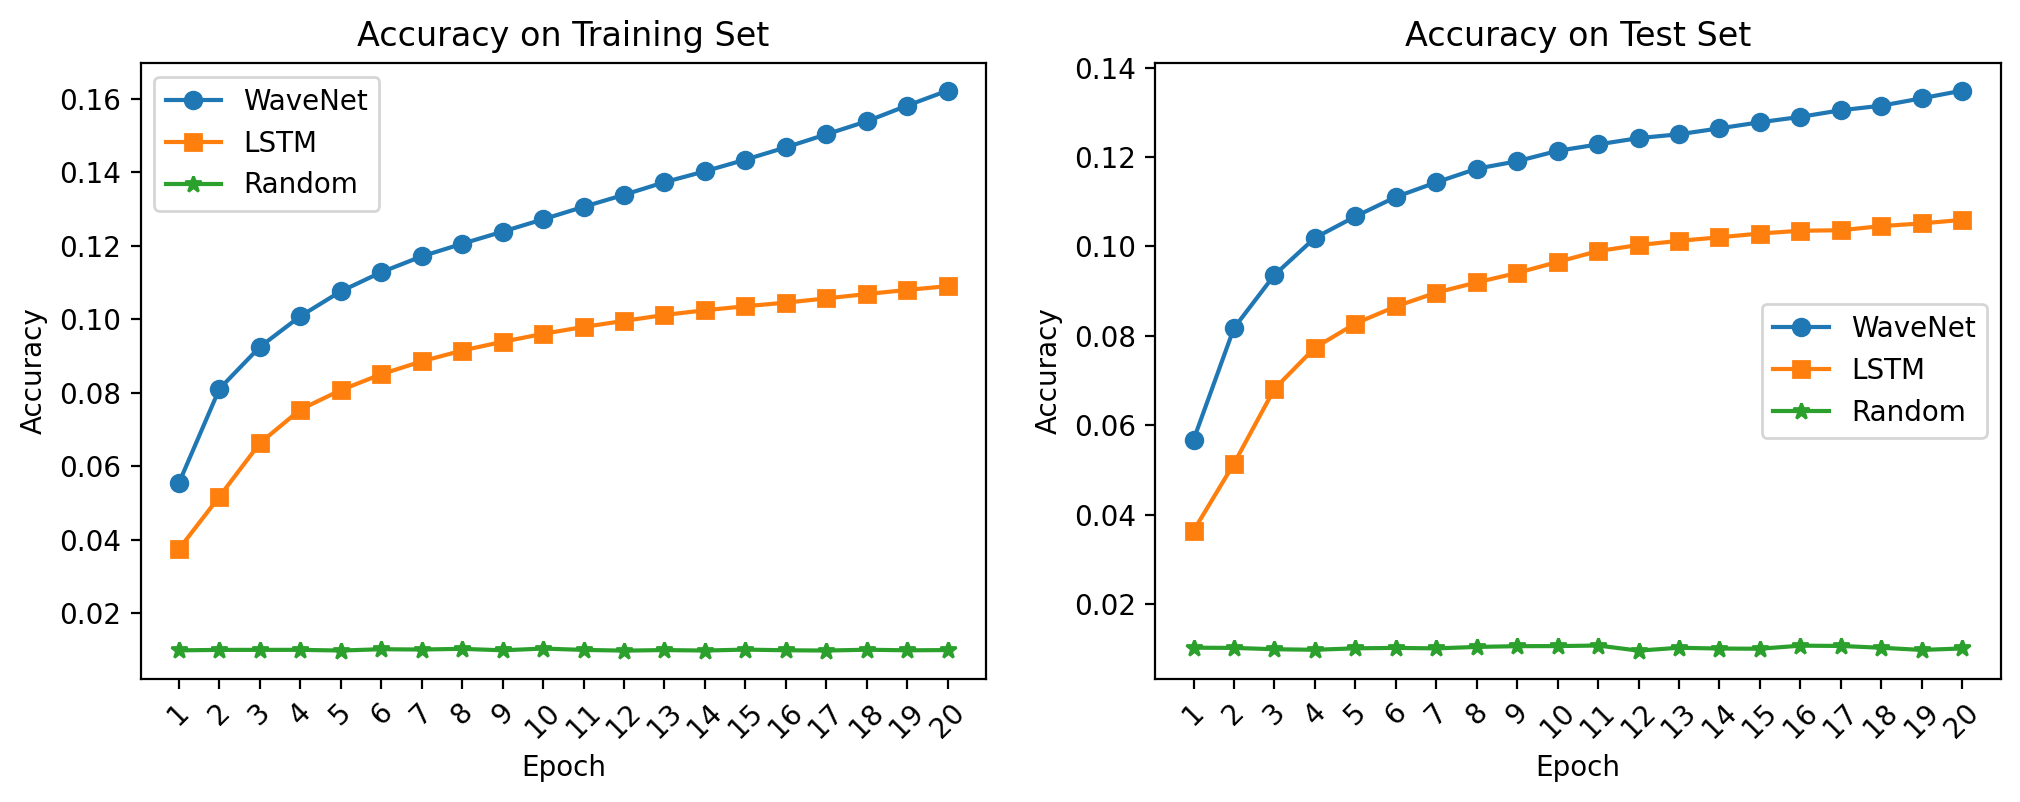

In [97]:
CONTEXTLENGTH = 32
wavenet_folder = os.path.join('training_records', f'wavenet-CL{CONTEXTLENGTH}')
lstm_folder = os.path.join('training_records', f'lstm-CL{CONTEXTLENGTH}')
random_folder = os.path.join('training_records', 'random')

wavenet_files = sorted(os.listdir(wavenet_folder))
lstm_files = sorted(os.listdir(lstm_folder))
random_files = sorted(os.listdir(random_folder))

wavenet_records = [json.load(open(os.path.join(wavenet_folder, f), 'r')) for f in wavenet_files]
lstm_records = [json.load(open(os.path.join(lstm_folder, f), 'r')) for f in lstm_files]
random_records = [json.load(open(os.path.join(random_folder, f), 'r')) for f in random_files]


metric = 'train_accuracy'  
wavenet_train_metric = [record[metric] for record in wavenet_records]
lstm_train_metric = [record[metric] for record in lstm_records]
random_train_metric = [record[metric] for record in random_records]

metric = 'val_accuracy'
wavenet_test_metric = [record[metric] for record in wavenet_records]
lstm_test_metric = [record[metric] for record in lstm_records]
random_test_metric = [record[metric] for record in random_records]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(range(len(wavenet_train_metric)), wavenet_train_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_train_metric)), lstm_train_metric, label='LSTM', marker='s')
plt.plot(range(len(random_train_metric)), random_train_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_train_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Training Set')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(wavenet_test_metric)), wavenet_test_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_test_metric)), lstm_test_metric, label='LSTM', marker='s')
plt.plot(range(len(random_test_metric)), random_test_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_test_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Test Set')
plt.legend()

plt.show()

From the above results, we can see that WaveNet has the highest accuracy on both training and test sets, followed by LSTM and Random. 

##### Average Cross Entropy Loss Per Token

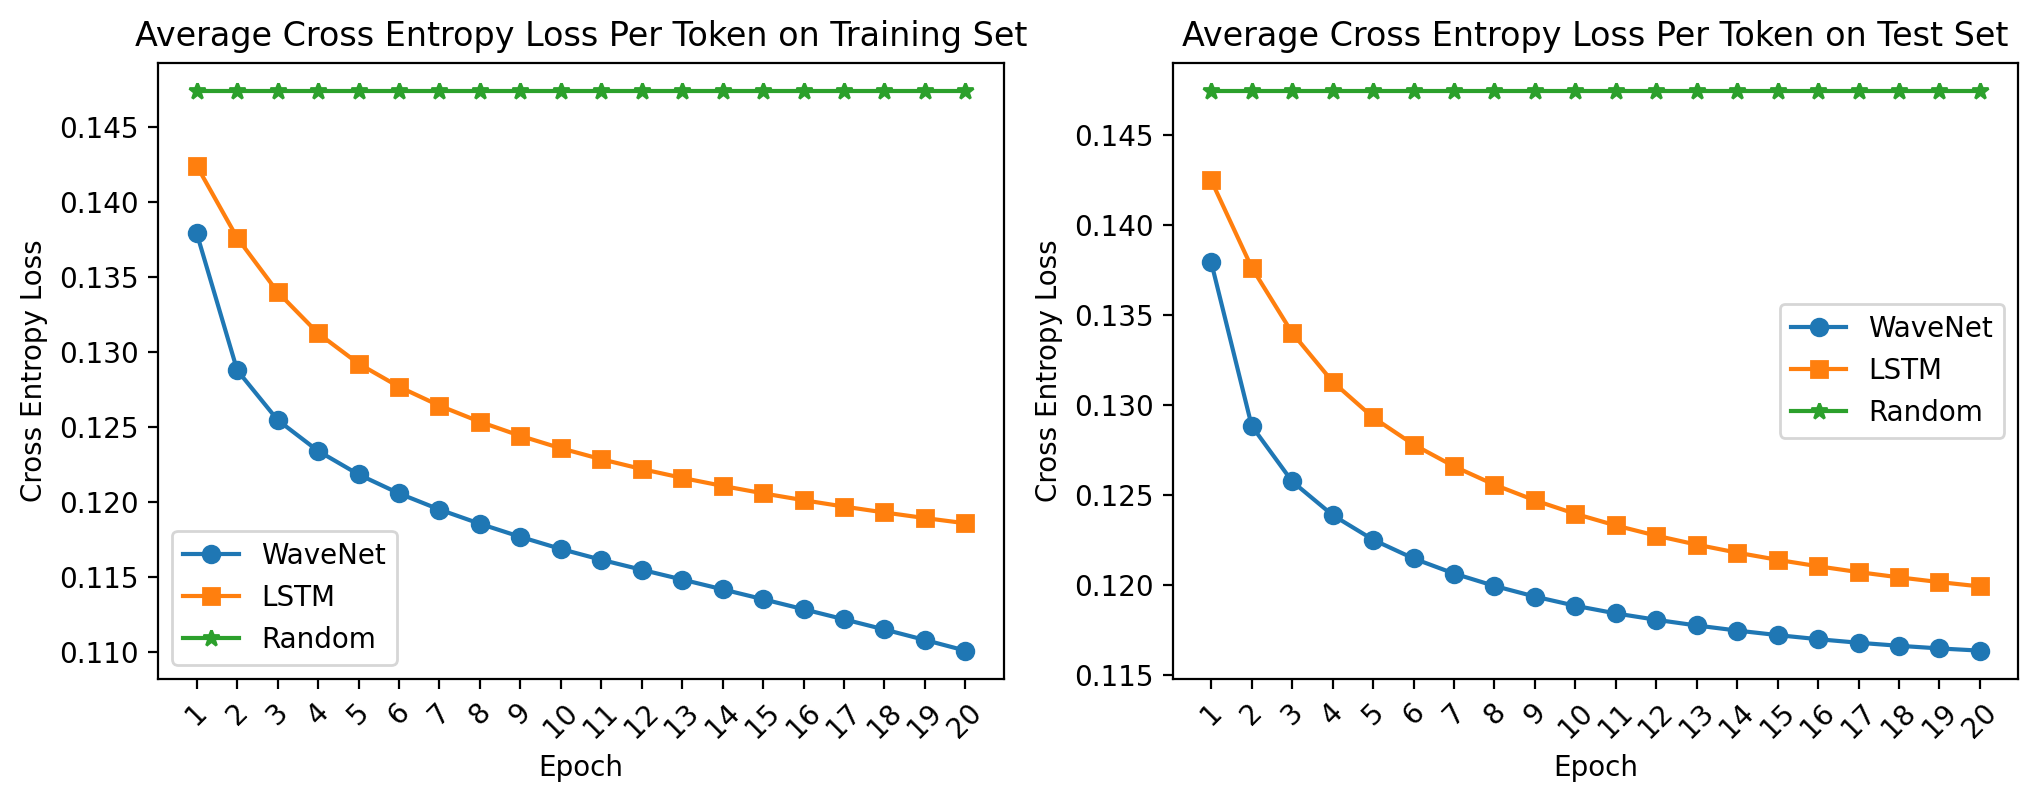

In [98]:
CONTEXTLENGTH = 32
wavenet_folder = os.path.join('training_records', f'wavenet-CL{CONTEXTLENGTH}')
lstm_folder = os.path.join('training_records', f'lstm-CL{CONTEXTLENGTH}')
random_folder = os.path.join('training_records', 'random')

wavenet_files = sorted(os.listdir(wavenet_folder))
lstm_files = sorted(os.listdir(lstm_folder))
random_files = sorted(os.listdir(random_folder))

wavenet_records = [json.load(open(os.path.join(wavenet_folder, f), 'r')) for f in wavenet_files]
lstm_records = [json.load(open(os.path.join(lstm_folder, f), 'r')) for f in lstm_files]
random_records = [json.load(open(os.path.join(random_folder, f), 'r')) for f in random_files]


metric = 'train_loss'  
wavenet_train_metric = [record[metric] for record in wavenet_records]
lstm_train_metric = [record[metric] for record in lstm_records]
random_train_metric = [record[metric] for record in random_records]

metric = 'val_loss'
wavenet_test_metric = [record[metric] for record in wavenet_records]
lstm_test_metric = [record[metric] for record in lstm_records]
random_test_metric = [record[metric] for record in random_records]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(range(len(wavenet_train_metric)), wavenet_train_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_train_metric)), lstm_train_metric, label='LSTM', marker='s')
plt.plot(range(len(random_train_metric)), random_train_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_train_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Average Cross Entropy Loss Per Token on Training Set')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(wavenet_test_metric)), wavenet_test_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_test_metric)), lstm_test_metric, label='LSTM', marker='s')
plt.plot(range(len(random_test_metric)), random_test_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_test_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Average Cross Entropy Loss Per Token on Test Set')
plt.legend()

plt.show()

From the above results, we can see that WaveNet has the lowest average cross entropy loss per token on both training and test sets, followed by LSTM and Random.

##### Perplexity

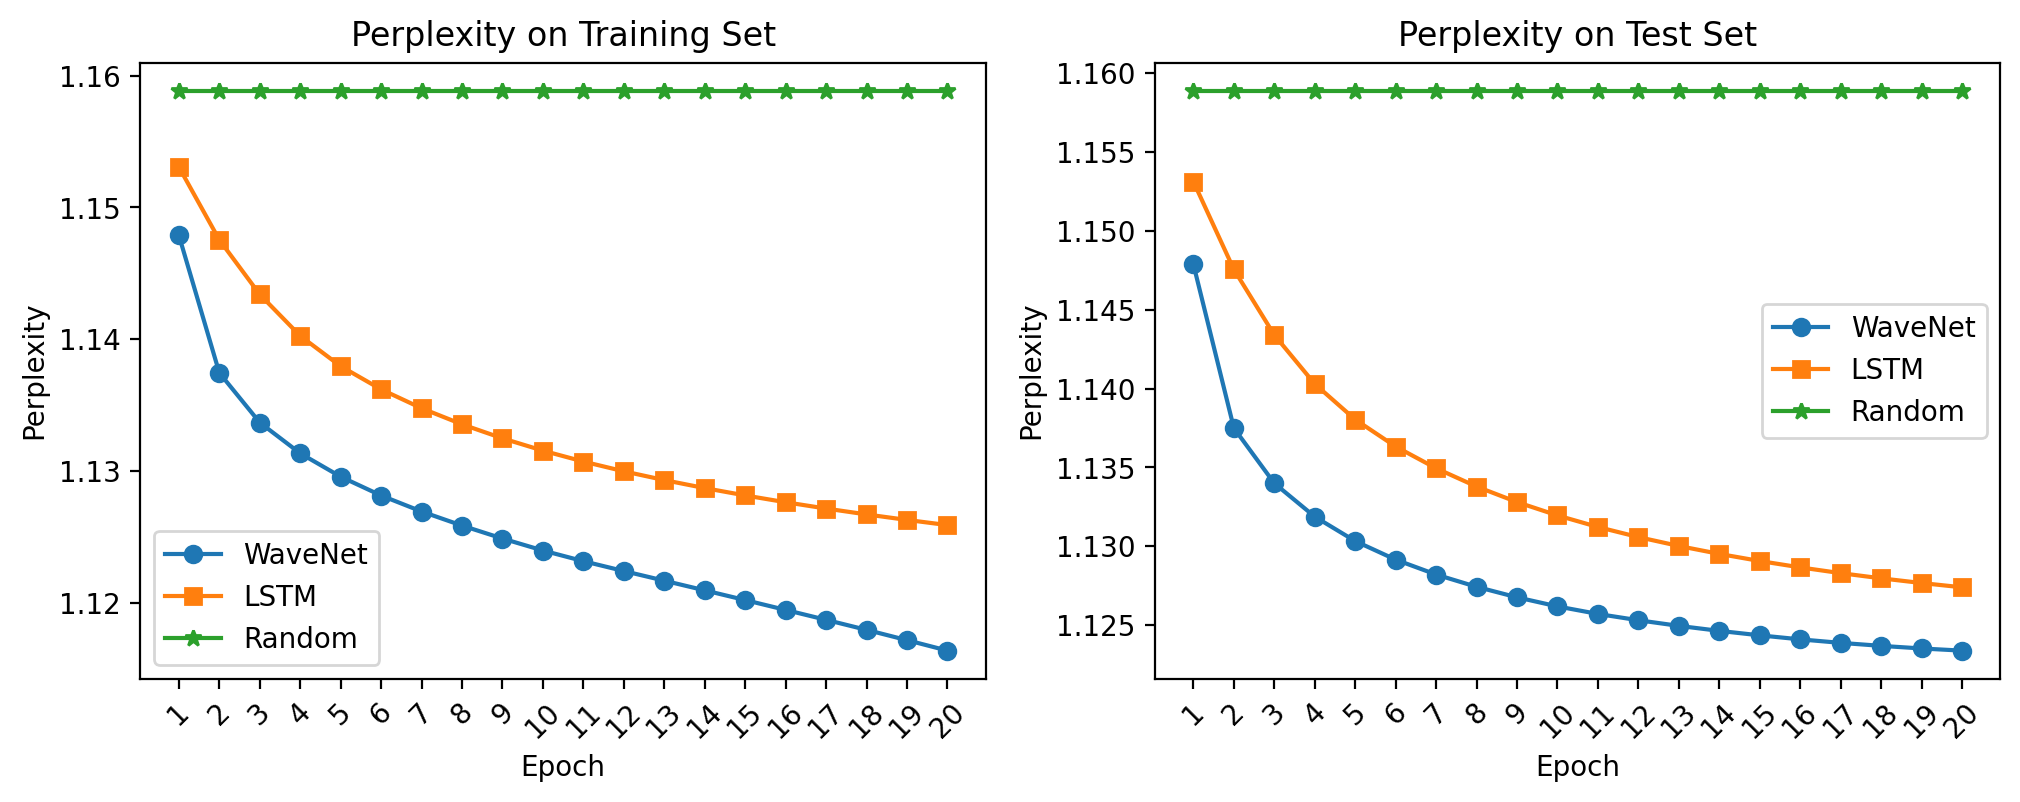

In [99]:
CONTEXTLENGTH = 32
wavenet_folder = os.path.join('training_records', f'wavenet-CL{CONTEXTLENGTH}')
lstm_folder = os.path.join('training_records', f'lstm-CL{CONTEXTLENGTH}')
random_folder = os.path.join('training_records', 'random')

wavenet_files = sorted(os.listdir(wavenet_folder))
lstm_files = sorted(os.listdir(lstm_folder))
random_files = sorted(os.listdir(random_folder))

wavenet_records = [json.load(open(os.path.join(wavenet_folder, f), 'r')) for f in wavenet_files]
lstm_records = [json.load(open(os.path.join(lstm_folder, f), 'r')) for f in lstm_files]
random_records = [json.load(open(os.path.join(random_folder, f), 'r')) for f in random_files]


metric = 'train_loss'  
wavenet_train_metric = [np.exp(record[metric]) for record in wavenet_records]
lstm_train_metric = [np.exp(record[metric]) for record in lstm_records]
random_train_metric = [np.exp(record[metric]) for record in random_records]

metric = 'val_loss'
wavenet_test_metric = [np.exp(record[metric]) for record in wavenet_records]
lstm_test_metric = [np.exp(record[metric]) for record in lstm_records]
random_test_metric = [np.exp(record[metric]) for record in random_records]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(range(len(wavenet_train_metric)), wavenet_train_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_train_metric)), lstm_train_metric, label='LSTM', marker='s')
plt.plot(range(len(random_train_metric)), random_train_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_train_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity on Training Set')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(wavenet_test_metric)), wavenet_test_metric, label='WaveNet', marker='o')
plt.plot(range(len(lstm_test_metric)), lstm_test_metric, label='LSTM', marker='s')
plt.plot(range(len(random_test_metric)), random_test_metric, label='Random', marker='*')
plt.xticks(range(len(wavenet_test_metric)), [i for i in range(1, len(wavenet_files) + 1)], rotation=45)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity on Test Set')
plt.legend()

plt.show()

From the above results, we can see that WaveNet has the lower perplexity on both training and test sets, followed by LSTM and Random.

##### Some Comments about the Results
The above accuracy is not high for a classification of 160 classes. This is due to we only used a small subset of the dataset for training because of the limited computation power. We used 8000 sequences for training and 2000 sequences for testing. If we use more data, we can expect the accuracy to be higher. However, we kept learning rate, numeber of epochs the same for both WaveNet and LSTM. Also, we tried the best to make sure that the hyperparameters are the same for both models. So the comparison is fair.

### <span style="color:red">4. Discussion of related work</span>

1. How has this dataset been used in the past?
Many papers have used this dataset, the following are some examples:
    * **[MusicBERT: Symbolic Music Understanding with Large-Scale Pre-Training](https://arxiv.org/pdf/2106.05630v1)**: This paper pretrained a BERT-like model on symbolic music data(MIDI format). In addition to NLP pretraining techniques, they also used music-specific techniques such as OctupleMIDI encoding and bar-level masking. They did experiments on 4 music understanding tasks including melody extraction, accompaniment suggestion, genre classification, and style classifcation.  

    * **[MT3: Multi-Task Multitrack Music Transcription](https://arxiv.org/pdf/2111.03017v4)**: This paper proposed a general-purpose Transformer model can perform multi-task AMT(Automatic Music Transcription), jointly transcribing arbitrary combinations of musical instruments across several transcription datasets. The authors borrowed the idea of sequence-to-sequence transfer learning for low resource NLP.
    
    * **[Enabling Factorized Piano Music Modeling and Generation with the MAESTRO Dataset](https://openreview.net/pdf?id=r1lYRjC9F7)**: This paper used this dataset to train a Wave2Midi2Wave model. They proposed that note representation(midi files) can be a good intermediate representation for music generation.


2. Has previous work approached the same task?
    * **[Symbolic Music Generation with Diffusion Models](https://arxiv.org/pdf/2103.16091)**: Symbolic music provides discrete representations of music, this paper proposed a technique to parameterize discrete domain into the continuous domain and then train a diffusion model on the continuous domain.

    * **[Symbolic Music Generation with Transformer-GANs](https://ojs.aaai.org/index.php/AAAI/article/view/16117)**: The previous work has been using autoaggressive models for music generation, however, exposure bias is a problem especially for long sequences. Exposure bias mean that mistakes accumulate during the inference time. For example, if the model generates a wrong token early, it builds on that error, and the sequence quickly deteriorates. This paper proposed a Transformer-GAN model to address this problem. In detailes, they used a pre-trained Span-BERT model for the discriminator of the GAN, which helped with training stability. They also used the Gumbel-Softmax trick to obtain a differentiable approximation of the sampling process. This makes discrete sequences amenable to optimization in GANs. 
    
    * **[Theme Transformer: Symbolic Music Generation With Theme-Conditioned Transformer](https://ieeexplore.ieee.org/abstract/document/9740506?casa_token=qtzg_ScKKKIAAAAA:2vZt-K6d5k-NZj7l7co12_9A00ZKcoujKWc1RfAw6TtueprWG-cO-c6MZYu3sQbD1GcWPlkI8A)**: To generate music conditioning on a specific theme, the previous work used conditioning sequence as a priming sequence and asked the transformer to generate future continuation. However, this approach cannot gaurantee the conditioning sequence would develop or even simply repeat itself in the generated continuation. This paper explicitly manifests the conditioning sequence in the transformer architecture mutiple times while training and generation.

3. Compare and contrast our approach with previous work.
    * I found that most of the recent music generation taskes use transformer-based models. Also, they use a much larger dataset then in this assignment. So I think that our approach is not really comparable to the previous work.

### <span style="color:red">5. Music Generation</span>


In [ ]:
def generate_notes_chords(seed, receptive_field, model, device, num_notes):
    
    set_seed(seed)
    notes_chords_ids = []
    probs = []
    for note_chord in selectedNCInfo:
        notes_chords_ids.append(selectedNCInfo[note_chord]['id'])
        probs.append(selectedNCInfo[note_chord]['prob'])
    
    generated_sequence = np.random.choice(notes_chords_ids, size=receptive_field, p=probs)

    model.to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(num_notes + receptive_field):
            input_sequence = torch.tensor(generated_sequence[-receptive_field:], dtype=torch.long).unsqueeze(0).to(device)
            logits = model(input_sequence)  # [1, seq_len, num_classes]
            next_note_chord_logits = logits[0, -1, :]
            # apply softmax to get probabilities
            next_note_chord_probs = F.softmax(next_note_chord_logits, dim=0)
            # sample from the probabilities
            next_note_chord_id = torch.multinomial(next_note_chord_probs, num_samples=1).item()
            # or use argmax to get the most probable note/chord
            # next_note_chord_id = torch.argmax(next_note_chord_probs).item()
            generated_sequence = np.append(generated_sequence, next_note_chord_id)
    generated_sequence = generated_sequence[receptive_field:]
    generated_sequence = [id2note[id] for id in generated_sequence]
    return generated_sequence



# This function is borrowed from https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
def convert_to_midi(prediction_output, save_dir):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                cn = int(current_note)
                new_note = music21.note.Note(cn)
                new_note.storedInstrument = music21.instrument.Piano()
                notes.append(new_note)
                
            new_chord = music21.chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        
        else:
            new_note = music21.note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = music21.instrument.Piano()
            output_notes.append(new_note)

        offset += 1

    midi_stream = music21.stream.Stream(output_notes)
    midi_stream.write('midi', fp=save_dir)


def convert_midi_to_wav(midi_file, wav_file):
    fs = FluidSynth(sound_font="FluidR3Mono_GM.sf3")
    fs.midi_to_audio(midi_file, wav_file)



# define hyperparameters
CONTEXTLENGTH = 32
EMBED_DIM = 128
VOCAB_SIZE = len(selectedNCInfo)
RESIDUAL_SIZE = EMBED_DIM 
SKIP_SIZE = EMBED_DIM 
END_SIZE = EMBED_DIM * 2
STACK_SIZE = 2
DILATION_DEPTH = 4
DEVICE = 'cpu'
NUM_NOTES = 100
SEED = 3
model = WaveNet(embed_dim=EMBED_DIM, 
                num_class=VOCAB_SIZE, 
                residual_size=RESIDUAL_SIZE, 
                skip_size=SKIP_SIZE, 
                end_size=END_SIZE,
                stack_size=STACK_SIZE, 
                dilation_depth=DILATION_DEPTH)


# load the saved model weights
model_savedir = os.path.join('model_weights', f'wavenet-CL{CONTEXTLENGTH}' , 'epoch_20.pt')
model.load_state_dict(torch.load(model_savedir, map_location=DEVICE))

# generate music
generated_seq = generate_notes_chords(seed=SEED, receptive_field=2**DILATION_DEPTH, model=model, device=DEVICE, num_notes=NUM_NOTES)
convert_to_midi(generated_seq, save_dir=os.path.join('generated_music', f'symbolic_unconditioned.mid'))
convert_midi_to_wav(midi_file=os.path.join('generated_music', f'symbolic_unconditioned.mid'), 
                    wav_file=os.path.join('generated_music', f'symbolic_unconditioned.wav'))

/var/folders/66/vd6zw5p56rjf4rt4h_qfb4900000gn/T/ipykernel_72333/1533594299.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save

[INFO] Seed set to 3
FluidSynth runtime version 2.4.6
Copyright (C) 2000-2025 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'generated_music/symbolic_unconditioned.wav'..
